[utt1]
  Predicted: hello this is it this sentence
  Expected : hello this a test sentence
  Latency  : 1.180s

[utt2]
  Predicted: hello i'm a programmer and by i'm from turkey
  Expected : hello i'm a programmer and i'm from turkey
  Latency  : 1.222s


--- Overall Evaluation ---
Samples: 2
WER: 0.308 (30.77%)
CER: 0.167 (16.67%)


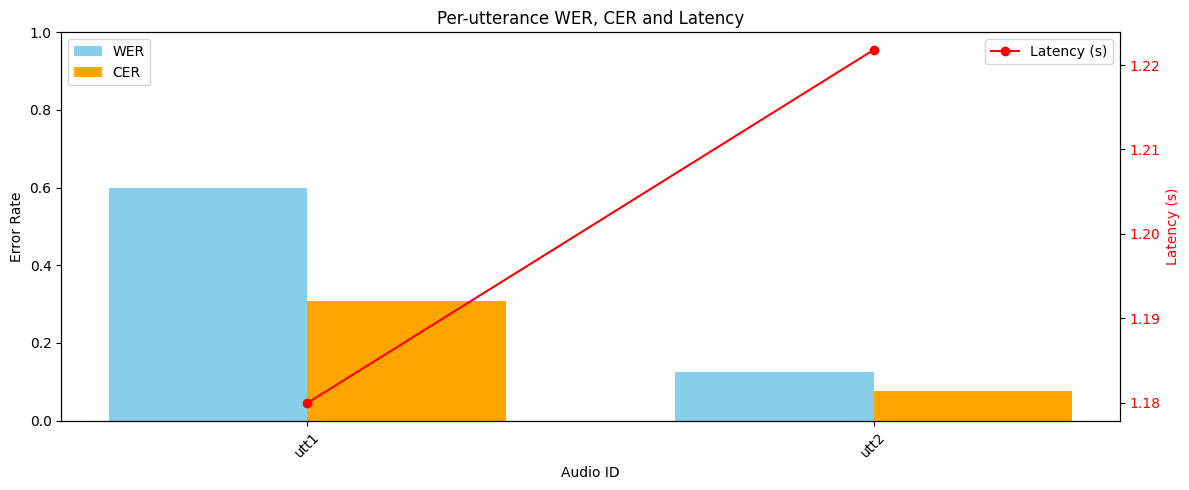

In [ ]:
import wave, json, os, time
from vosk import Model, KaldiRecognizer
from jiwer import wer, cer, ToLowerCase, RemovePunctuation, RemoveMultipleSpaces, Strip, Compose
import matplotlib.pyplot as plt
import numpy as np

MODEL_PATH = r"C:\Users\Admin\Desktop\vosk-model-small-en-us-0.15"
TEST_DIR = "test_set"  # WAV faylları
PRED_PATH = "predicted.json"
GT_PATH = "expected.json"
SAMPLE_RATE = 16000
CHUNK_BYTES = 4000 * 2

# Load model
model = Model(MODEL_PATH)
preds = []
latencies = []

# Load ground truth
def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        arr = json.load(f)
    return {item["id"]: item["text"] for item in arr}

gt = load_json(GT_PATH)

# WAV faylları oxu
wav_files = sorted([f for f in os.listdir(TEST_DIR) if f.lower().endswith(".wav")])

for wav_name in wav_files:
    wav_path = os.path.join(TEST_DIR, wav_name)
    utt_id = os.path.splitext(wav_name)[0]

    wf = wave.open(wav_path, "rb")
    assert wf.getframerate() == SAMPLE_RATE
    assert wf.getnchannels() == 1

    rec = KaldiRecognizer(model, SAMPLE_RATE)

    start_time = time.time()
    while True:
        data = wf.readframes(CHUNK_BYTES // 2)
        if len(data) == 0:
            break
        rec.AcceptWaveform(data)
    end_time = time.time()

    latency = end_time - start_time
    latencies.append(latency)

    res = json.loads(rec.Result())
    predicted_text = res.get("text", "").strip()
    expected_text = gt.get(utt_id, "")

    print(f"[{utt_id}]")
    print(f"  Predicted: {predicted_text}")
    print(f"  Expected : {expected_text}")
    print(f"  Latency  : {latency:.3f}s\n")

    preds.append({"id": utt_id, "text": predicted_text})
    wf.close()

# Save predicted.json
with open(PRED_PATH, "w", encoding="utf-8") as f:
    json.dump(preds, f, ensure_ascii=False, indent=2)

# =========================
# WER / CER Evaluation
# =========================

ids = sorted(set(gt.keys()) & set([p["id"] for p in preds]))
refs = [gt[i] for i in ids]
hyps = [p["text"] for p in preds if p["id"] in ids]

transform = Compose([ToLowerCase(), RemovePunctuation(), RemoveMultipleSpaces(), Strip()])
refs_t = [transform(r) for r in refs]
hyps_t = [transform(h) for h in hyps]

w = wer(refs_t, hyps_t)
c = cer(refs_t, hyps_t)

print("\n--- Overall Evaluation ---")
print(f"Samples: {len(ids)}")
print(f"WER: {w:.3f} ({w*100:.2f}%)")
print(f"CER: {c:.3f} ({c*100:.2f}%)")

per_utterance_wer = [wer(refs_t[i], hyps_t[i]) for i in range(len(ids))]
per_utterance_cer = [cer(refs_t[i], hyps_t[i]) for i in range(len(ids))]

# =============================================
# Bar chart: WER & CER per utterance + Latency
# =============================================
x = np.arange(len(ids))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12,5))

# WER & CER bars
ax1.bar(x - width/2, per_utterance_wer, width=width, color='skyblue', label='WER')
ax1.bar(x + width/2, per_utterance_cer, width=width, color='orange', label='CER')
ax1.set_xlabel('Audio ID')
ax1.set_ylabel('Error Rate')
ax1.set_xticks(x)
ax1.set_xticklabels(ids, rotation=45)
ax1.set_ylim(0,1)
ax1.legend(loc='upper left')

# Latency line
ax2 = ax1.twinx()
ax2.plot(x, latencies, color='red', marker='o', label='Latency (s)')
ax2.set_ylabel('Latency (s)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.title("Per-utterance WER, CER and Latency")
plt.tight_layout()
plt.show()
